In [1]:
import numpy as np
import nest
import matplotlib.pyplot as plt
from matplotlib import rcParams 
from matplotlib.widgets import Button, Slider


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.3
 Built: May  5 2022 07:35:57

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.




May 27 13:22:31 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.01 ms.

May 27 13:22:31 NodeManager::prepare_nodes [Info]: 
    Preparing 51 nodes for simulation.

May 27 13:22:31 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 51
    Simulation time (ms): 20
    Number of OpenMP threads: 16
    Number of MPI processes: 1

May 27 13:22:31 SimulationManager::run [Info]: 
    Simulation finished.
10.0 us


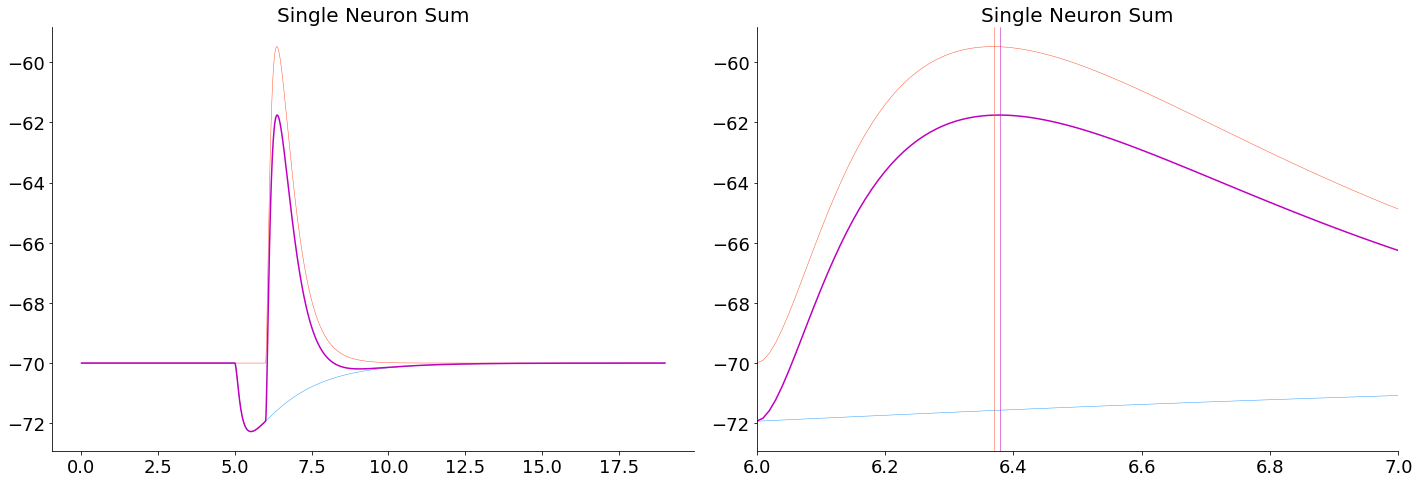

In [94]:
tone = 20
time_sim = 20
lim = time_sim
delta_inh = -1

taus = np.zeros(4)
taus[:] =  [0.2, 0.2, 0.5, 1.5] #default: [0.2, 2, 0.2, 2] #40: [0.2, 0.1, 0.5, 0.1] #15: [0.2, 0.1, 0.2, 0.01] # 85 [0.2, 0.1, 1.2, 0.18] #65: [0.2, 0.1, 0.75, 0.14]
w_ratio = 1

c_mso = 1
we = 3
wi = -we*w_ratio
delays_mso = [5,5+delta_inh] #ms
weights_mso = [we,wi]
v_th = -40
v_m = -70

nest.ResetKernel()
nest.local_num_threads = 16
nest.resolution = 0.01 

ipsi_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1, time_sim+1, 1000/tone),2)})


mso = nest.Create('iaf_cond_beta', 3)

for i in range(3):
    mso[i].set(V_m = v_m, V_th = v_th, C_m = c_mso, tau_rise_ex = taus[0], tau_rise_in = taus[1], tau_decay_ex = taus[2], tau_decay_in = taus[3])

s = nest.Create('spike_recorder')

m = nest.Create('multimeter', 1, {"record_from": ['V_m']})
nest.SetStatus(m, {'interval': 0.01})

nest.Connect(mso, s, 'all_to_all')
nest.Connect(ipsi_e, s, 'one_to_one')

nest.Connect(m, mso, 'all_to_all')

nest.Connect(ipsi_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
nest.Connect(ipsi_e, mso[1], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[1]})
nest.Connect(ipsi_e, mso[2], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
nest.Connect(ipsi_e, mso[2], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[1]})


nest.Simulate(time_sim)
#data = s.get('events')
pot = m.get('events')

text_color = 'black' 
rcParams['text.color'] = text_color 
rcParams['axes.labelcolor'] = text_color 
rcParams['xtick.color'] = text_color 
rcParams['ytick.color'] = text_color 
plt.rc('font', size=16)          # controls default text sizes 
plt.rc('axes', titlesize=20)     # fontsize of the axes title 
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels 
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels 
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels 
plt.rc('legend', fontsize=16)    # legend fontsize 
plt.rc('figure', titlesize=26)  # fontsize of the figure title

col = ['#FF5733', '#33A1FD', '#FFC300', '#1E90FF', 'm', 'g', 'brown', 'grey']
fig, ax = plt.subplots(1,2, figsize=(20,7))

for i in range(2):
    ax[i].set_title('Single Neuron Sum')
    ax[i].plot(pot['times'][np.where(pot['senders'] == mso[0].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[0].get('global_id'))], color = col[0], linewidth = 0.5)
    ax[i].plot(pot['times'][np.where(pot['senders'] == mso[1].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[1].get('global_id'))], color = col[1], linewidth = 0.5)
    ax[i].plot(pot['times'][np.where(pot['senders'] == mso[2].get('global_id'))], pot['V_m'][np.where(pot['senders'] == mso[2].get('global_id'))], color = col[4])
    ax[i].spines['top'].set_visible(False) 
    ax[i].spines['right'].set_visible(False)
    
ax[1].set_xlim([6,7])
t1 = pot['times'][max(range(len(pot['V_m'][np.where(pot['senders'] == mso[2])])), key=pot['V_m'][np.where(pot['senders'] == mso[2])].__getitem__)]
t2 = pot['times'][max(range(len(pot['V_m'][np.where(pot['senders'] == mso[0])])), key=pot['V_m'][np.where(pot['senders'] == mso[0])].__getitem__)]
ax[1].axvline(t1, color = col[4], linewidth = 0.5)
ax[1].axvline(t2, color = col[0], linewidth = 0.5)
peak_shift = (t1 - t2)*1000
print(round(peak_shift,4), 'us')
fig.tight_layout()

In [95]:
def simulate_mso(delta_inh, taus, w_ratio, tone, time_sim):
    
    nest.ResetKernel()
    nest.local_num_threads = 16
    nest.resolution = 0.01 
    
    wi = -we*w_ratio
    delays_mso = [5,5+delta_inh] #ms
    weights_mso = [we,wi]
    #c_mso = 1
    
    ipsi_e = nest.Create("spike_generator", 1, params={"spike_times": np.around(np.arange(1, time_sim+1, 1000/tone),2)})

    mso = nest.Create('iaf_cond_beta', 2)

    for i in range(2):
        mso[i].set(V_m = v_m, V_th = v_th, C_m = c_mso, tau_rise_ex = taus[0], tau_rise_in = taus[1], tau_decay_ex = taus[2], tau_decay_in = taus[3])

    m = nest.Create('multimeter', 1, {"record_from": ['V_m']})
    nest.SetStatus(m, {'interval': 0.01})

    nest.Connect(m, mso, 'all_to_all')

    nest.Connect(ipsi_e, mso[0], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
    nest.Connect(ipsi_e, mso[1], 'one_to_one', syn_spec = {"weight":weights_mso[0], "delay": delays_mso[0]})
    nest.Connect(ipsi_e, mso[1], 'one_to_one', syn_spec = {"weight":weights_mso[1], "delay": delays_mso[1]})
    
    nest.Simulate(time_sim)
    
    pot = m.get('events')
    
    t1 = pot['times'][max(range(len(pot['V_m'][np.where(pot['senders'] == mso[1])])), key=pot['V_m'][np.where(pot['senders'] == mso[1])].__getitem__)]
    t2 = pot['times'][max(range(len(pot['V_m'][np.where(pot['senders'] == mso[0])])), key=pot['V_m'][np.where(pot['senders'] == mso[0])].__getitem__)]
    peak_shift = (t1 - t2)*1000
    
    return(peak_shift)

In [96]:
delta_inh_array = np.arange(-1.25,1.25,0.25)
peak_shift_array = np.zeros_like(delta_inh_array)
for i in range(len(delta_inh_array)):
    delta_inh = delta_inh_array[i]
    peak_shift_array[i] = simulate_mso(delta_inh, taus, w_ratio, tone, time_sim)


May 27 13:22:33 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.01 ms.

May 27 13:22:33 NodeManager::prepare_nodes [Info]: 
    Preparing 34 nodes for simulation.

May 27 13:22:33 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 34
    Simulation time (ms): 20
    Number of OpenMP threads: 16
    Number of MPI processes: 1

May 27 13:22:33 SimulationManager::run [Info]: 
    Simulation finished.

May 27 13:22:33 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.01 ms.

May 27 13:22:33 NodeManager::prepare_nodes [Info]: 
    Preparing 34 nodes for simulation.

May 27 13:22:33 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 34
    Simulation time (ms): 20
    Number of OpenMP threads: 16
    Number of MPI processes: 1

May 27 13:22:33 SimulationManager::run [Info]: 
    Simulation finished.

May 27 13:22:33 SimulationManager::set_status [Info]: 
    Temporal resolution ch

[-1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75  1.  ]
[ 10.  10.  10.  10.   0. -50. -90.   0.   0.   0.]


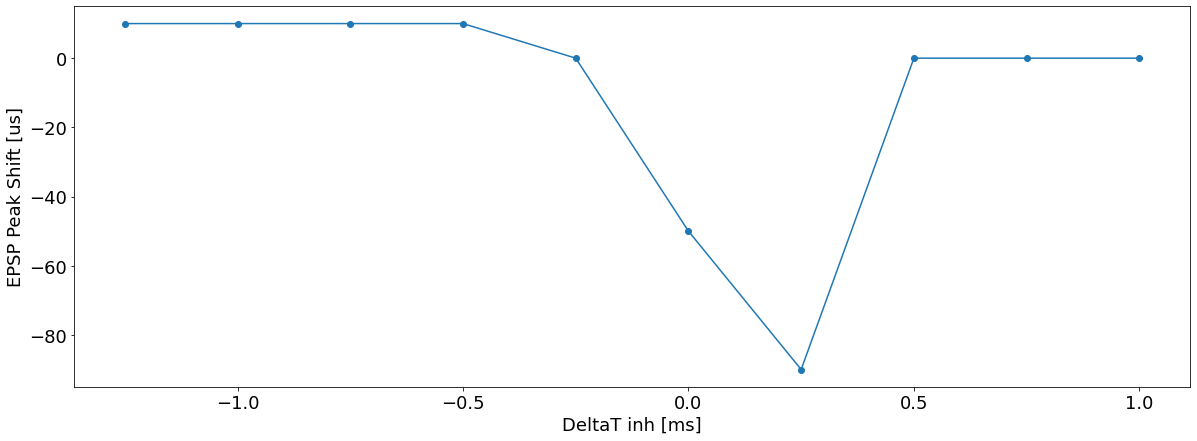

In [97]:
fig, ax = plt.subplots(1, figsize=(20,7))
    
ax.plot(delta_inh_array, peak_shift_array, 'o-')
ax.set_xlabel("DeltaT inh [ms]")
ax.set_ylabel("EPSP Peak Shift [us]")
print(np.round(delta_inh_array,2))
print(peak_shift_array)

[-1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75  1.  ]
[  0.   0.   0.   0. -10. -40. -40.   0.   0.   0.]


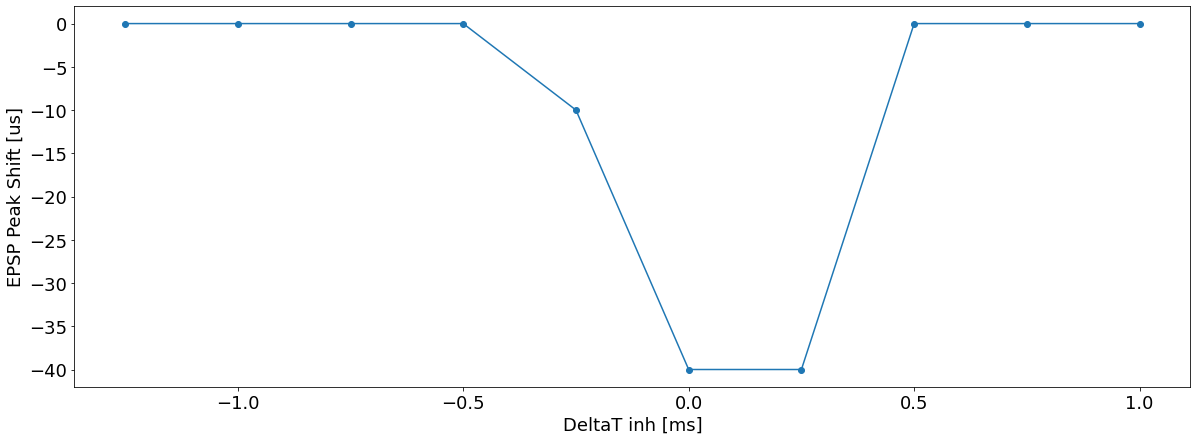

In [82]:
fig, ax = plt.subplots(1, figsize=(20,7))
    
ax.plot(delta_inh_array, peak_shift_array, 'o-')
ax.set_xlabel("DeltaT inh [ms]")
ax.set_ylabel("EPSP Peak Shift [us]")
print(delta_inh_array)
print(peak_shift_array)